<a href="https://colab.research.google.com/github/alarcon7a/rt-detr/blob/main/RT_DETR.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install -q git+https://github.com/huggingface/transformers.git

In [ ]:
import torch
import requests
from PIL import Image
from transformers import RTDetrForObjectDetection, RTDetrImageProcessor

model_name = "PekingU/rtdetr_r50vd_coco_o365"
image_processor = RTDetrImageProcessor.from_pretrained(model_name)
model = RTDetrForObjectDetection.from_pretrained(model_name)

## Inferencia sobre imagenes

In [ ]:
image = Image.open('/content/mara-luna.png')
inputs = image_processor(images=image, return_tensors="pt")
with torch.no_grad():
    outputs = model(**inputs)
results = image_processor.post_process_object_detection(outputs, target_sizes=torch.tensor([image.size[::-1]]), threshold=0.6)

In [ ]:
results

[{'scores': tensor([0.9694, 0.7771]),
  'labels': tensor([16, 29]),
  'boxes': tensor([[159.9734, 190.1764, 713.4670, 855.5520],
          [105.4664,  38.4738, 705.3755, 527.8815]])}]

In [ ]:
model.config.id2label[16]

'dog'

In [ ]:
for result in results:
    for score, label_id, box in zip(result["scores"], result["labels"], result["boxes"]):
        score, label = score.item(), label_id.item()
        box = [round(i, 2) for i in box.tolist()]
        print(f"{model.config.id2label[label]}: {score:.2f} {box}")

dog: 0.97 [159.97, 190.18, 713.47, 855.55]
frisbee: 0.78 [105.47, 38.47, 705.38, 527.88]


In [ ]:
from transformers import pipeline

pipe = pipeline(model=model_name)
pipe(image)

Hardware accelerator e.g. GPU is available in the environment, but no `device` argument is passed to the `Pipeline` object. Model will be on CPU.


[{'score': 0.9694089889526367,
  'label': 'dog',
  'box': {'xmin': 159, 'ymin': 190, 'xmax': 713, 'ymax': 855}},
 {'score': 0.7771490812301636,
  'label': 'frisbee',
  'box': {'xmin': 105, 'ymin': 38, 'xmax': 705, 'ymax': 527}}]

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches

def plot_bbox(image, data):
   # Create a figure and axes
    fig, ax = plt.subplots()

    # Display the image
    ax.imshow(image)

    for result in results:
        for score, label_id, box in zip(result["scores"], result["labels"], result["boxes"]):
            # Unpack the bounding box coordinates
            x1, y1, x2, y2 = box
            # Create a Rectangle patch
            rect = patches.Rectangle((x1, y1), x2-x1, y2-y1, linewidth=1, edgecolor='r', facecolor='none')
            # Add the rectangle to the Axes
            ax.add_patch(rect)
            # Annotate the label
            label = model.config.id2label[label_id.item()]
            plt.text(x1, y1, label, color='white', fontsize=8, bbox=dict(facecolor='red', alpha=0.5))

        # Remove the axis ticks and labels
        ax.axis('off')

    # Show the plot
    plt.show()

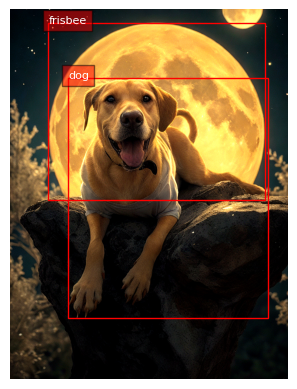

In [ ]:
plot_bbox(image,results)

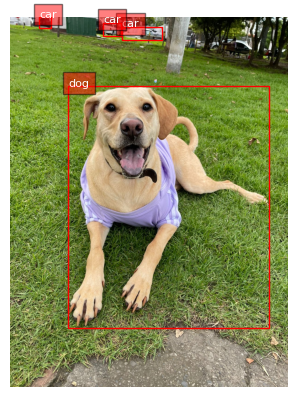

In [ ]:
image = Image.open('/content/mara.jpeg')
inputs = image_processor(images=image, return_tensors="pt")
with torch.no_grad():
    outputs = model(**inputs)
results = image_processor.post_process_object_detection(outputs, target_sizes=torch.tensor([image.size[::-1]]), threshold=0.6)
plot_bbox(image,results)

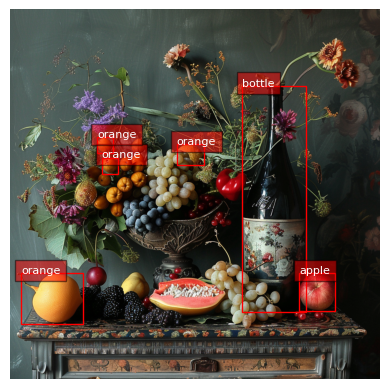

In [ ]:
image = Image.open('/content/bodegon.png')
inputs = image_processor(images=image, return_tensors="pt")
with torch.no_grad():
    outputs = model(**inputs)
results = image_processor.post_process_object_detection(outputs, target_sizes=torch.tensor([image.size[::-1]]), threshold=0.6)
plot_bbox(image,results)

## Sobre un video

In [ ]:
import cv2

In [ ]:
# Mover el modelo a la GPU si está disponible
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

RTDetrForObjectDetection(
  (model): RTDetrModel(
    (backbone): RTDetrConvEncoder(
      (model): RTDetrResNetBackbone(
        (embedder): RTDetrResNetEmbeddings(
          (embedder): Sequential(
            (0): RTDetrResNetConvLayer(
              (convolution): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
              (normalization): RTDetrFrozenBatchNorm2d()
              (activation): ReLU()
            )
            (1): RTDetrResNetConvLayer(
              (convolution): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
              (normalization): RTDetrFrozenBatchNorm2d()
              (activation): ReLU()
            )
            (2): RTDetrResNetConvLayer(
              (convolution): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
              (normalization): RTDetrFrozenBatchNorm2d()
              (activation): ReLU()
            )
          )
          (pooler): MaxPool2d(

In [ ]:
# Configurar el video
video_path = '/content/messi_video.mp4'
output_path = '/content/output.mp4'
cap = cv2.VideoCapture(video_path)

# Obtener propiedades del video
fps = cap.get(cv2.CAP_PROP_FPS)
width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
fourcc = cv2.VideoWriter_fourcc(*'mp4v')
out = cv2.VideoWriter(output_path, fourcc, fps, (width, height))

frame_count = 0
last_detections = []  # Para almacenar las últimas detecciones

while cap.isOpened():
    ret, frame = cap.read()
    if not ret:
        break

    # Procesar solo cada n fotogramas
    if frame_count % 1 == 0:
        # Convertir el fotograma a una imagen PIL
        image = Image.fromarray(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))

        # Procesar la imagen con RTDetr
        inputs = image_processor(images=image, return_tensors="pt").to(device)
        with torch.no_grad():
            outputs = model(**inputs)

        results = image_processor.post_process_object_detection(outputs, target_sizes=torch.tensor([image.size[::-1]]), threshold=0.6)

        # Actualizar las últimas detecciones
        last_detections = []
        for result in results:
            for score, label_id, box in zip(result["scores"], result["labels"], result["boxes"]):
                box = [int(i) for i in box.tolist()]
                label = model.config.id2label[label_id.item()]
                last_detections.append((box, label, score.item()))

    # Dibujar las últimas detecciones en el fotograma actual
    for box, label, score in last_detections:
        x1, y1, x2, y2 = box
        cv2.rectangle(frame, (x1, y1), (x2, y2), (0, 255, 0), 2)
        cv2.putText(frame, f"{label}: {score:.2f}", (x1, y1 - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.9, (0, 255, 0), 2)

    # Escribir el fotograma procesado en el archivo de salida
    out.write(frame)
    frame_count += 1

cap.release()
out.release()
print(f"Processed {frame_count} frames and saved to {output_path}")